In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import clear_output
import untils
from COBWEBNN import CobwebNN, CobwebNNTreeLayer, TestModel
# from encoder_decoder.resnet_encoder import Encoder, BasicBlockEnc
# from encoder_decoder.restnet_decoder import Decoder, BasicBlockDec

torch.Size([1, 1, 28, 28]) tensor([1])


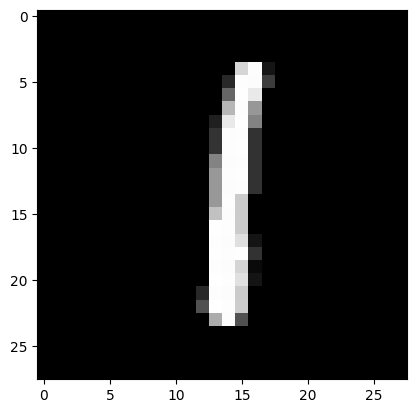

In [3]:
download = False
dataset_class = datasets.MNIST
mnist_transform = [transforms.ToTensor()]
# add normalization to the transform list such that all values are strictly greater than 0
# mnist_transform.append(transforms.Lambda(lambda x: x + 1e-5))
# normalize the data
mnist_transform.append(transforms.Normalize((0.1307,), (0.3081,)))

dataset_transform = transforms.Compose(mnist_transform)
mnist_train = dataset_class('data/MNIST', train=True, download=download, transform=dataset_transform)
mnist_test = dataset_class('data/MNIST', train=False, download=download, transform=dataset_transform)

# mnist_train.data.to('cuda')
# mnist_train.targets.to('cuda')
# # mnist_test.data.to('cuda')
# mnist_test.data.to('cuda')x
# mnist_test.targets.to('cuda')
# mnist_test.labels
# create a dataloader with
#  batch size 1
mnist_train_loader = DataLoader(mnist_train, batch_size=1, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(mnist_train_loader):
    print(data.shape, target)
    # print(data)
    # display the first image
    plt.imshow(data[0, 0].numpy(), cmap='gray')
    plt.show()
    break

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# randonly shuffle the training data
mnist_train_loader = DataLoader(mnist_train, batch_size=8, shuffle=True)

torch.Size([1, 3, 32, 32]) tensor([8])
tensor([[[[0.8314, 0.8431, 0.8627,  ..., 0.8235, 0.8275, 0.8353],
          [0.8196, 0.8275, 0.8392,  ..., 0.8000, 0.8039, 0.8078],
          [0.8275, 0.8314, 0.8431,  ..., 0.7961, 0.8039, 0.8039],
          ...,
          [0.7333, 0.7255, 0.4118,  ..., 0.9020, 0.9137, 0.9176],
          [0.7569, 0.7569, 0.7137,  ..., 0.9137, 0.9216, 0.9373],
          [0.8588, 0.8588, 0.8706,  ..., 0.9255, 0.9373, 0.9451]],

         [[0.8667, 0.8745, 0.8863,  ..., 0.8549, 0.8627, 0.8706],
          [0.8549, 0.8549, 0.8627,  ..., 0.8314, 0.8353, 0.8431],
          [0.8588, 0.8588, 0.8627,  ..., 0.8275, 0.8353, 0.8314],
          ...,
          [0.7451, 0.6902, 0.3137,  ..., 0.9020, 0.9176, 0.9255],
          [0.7529, 0.7490, 0.6980,  ..., 0.9137, 0.9216, 0.9412],
          [0.8588, 0.8667, 0.8824,  ..., 0.9373, 0.9529, 0.9686]],

         [[0.8745, 0.8824, 0.8980,  ..., 0.8627, 0.8627, 0.8627],
          [0.8706, 0.8745, 0.8824,  ..., 0.8431, 0.8431, 0.8431],
   

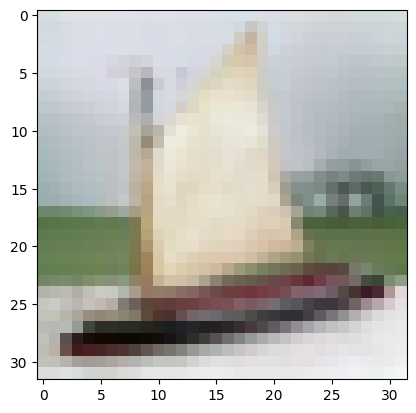

In [4]:
# load CIFAR10
download = False
dataset_class = datasets.CIFAR10
cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                        #  std=[0.247, 0.243, 0.261])
])

# dataset_transform = transforms.Compose(cifar10_transform)
cifar10_train = dataset_class('data/CIFAR10', train=True, download=download, transform=cifar10_transform)
cifar10_test = dataset_class('data/CIFAR10', train=False, download=download, transform=cifar10_transform)

cifar10_train_loader = DataLoader(cifar10_train, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(cifar10_train_loader):
    print(data.shape, target)
    print(data)
    # display the first image
    d = data[0].permute(1, 2, 0).numpy()
    # denomalrize
    # d = d * [0.247, 0.243, 0.261] + [0.4914, 0.4822, 0.4465]
    plt.imshow(d)
    plt.show()
    break

In [5]:
n_clusters = 2 # output cluster
leaves = nn.Parameter(torch.randn(4, 4))
print(leaves)
cluster_weight = nn.Parameter(torch.randn(n_clusters, 1))
sigmoid = nn.Sigmoid()
alpha = sigmoid(cluster_weight)
alpha = torch.cat((alpha, 1-alpha), dim=1).unsqueeze(-1)
print(alpha)

# mean_root = leaves * alpha
mean_root = leaves.view(-1, 2, 4) * alpha
print(mean_root.sum(dim=1))
# mean_root = mean_root.view(-1, 2, 4).sum(dim=1)
# mean_root

Parameter containing:
tensor([[-0.1002, -0.6092, -0.9798, -1.6091],
        [-1.1660, -1.0748,  1.3168, -0.6818],
        [-0.2223,  1.6871,  0.2284,  0.4676],
        [-0.5710,  0.0135, -0.5495, -1.0113]], requires_grad=True)
tensor([[[0.2906],
         [0.7094]],

        [[0.4854],
         [0.5146]]], grad_fn=<UnsqueezeBackward0>)
tensor([[-0.8563, -0.9394,  0.6494, -0.9513],
        [-0.4017,  0.8259, -0.1719, -0.2934]], grad_fn=<SumBackward1>)


In [6]:
# test encoder and decoder (VQ-VAE)
from encoder_decoder.vqvae_encoder import VQEncoder
from encoder_decoder.vqvae_decoder import VQDecoder

h_dim = 128
n_res_layers = 2
res_h_dim = 32
embedding_dim = 64

vq_encoder = VQEncoder(3, h_dim, n_res_layers, res_h_dim)
pre_quantization_conv = nn.Conv2d(h_dim, embedding_dim, kernel_size=1, stride=1)
vq_decoder = VQDecoder(embedding_dim, h_dim, n_res_layers, res_h_dim)

# test image
test_image = torch.randn(16, 3, 32, 32)
with torch.no_grad():
    z = vq_encoder(test_image)
    print(z.shape)
    print(z.max(), z.min())
    z = pre_quantization_conv(z)
    print(z.shape)
    print(z.max(), z.min())
    x_pred = vq_decoder(z)
    print(x_pred.shape)


torch.Size([16, 128, 8, 8])
tensor(0.4117) tensor(0.)
torch.Size([16, 64, 8, 8])
tensor(0.2285) tensor(-0.1996)
torch.Size([16, 3, 32, 32])


In [7]:
random_mat = torch.randn(16, 16)
relued = F.relu(random_mat)
print(relued.max(), relued.min())

random_w = torch.randn(16, 16)
random_b = torch.randn(16)
transformed = torch.matmul(random_w, random_mat) + random_b
print(transformed.min(), transformed.max())

tensor(2.4894) tensor(0.)
tensor(-15.8961) tensor(14.8598)


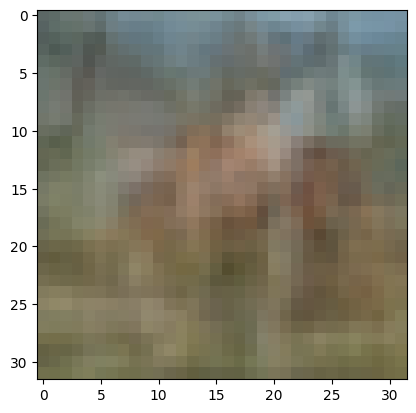

In [8]:
# plot the average of class 0 from CIFAR10
# get the mean of class 0
cifar10_class0 = []
for i, (data, target) in enumerate(cifar10_train_loader):
    if target == 7:
        cifar10_class0.append(data)
    if len(cifar10_class0) == 10:
        break

cifar10_class0 = torch.cat(cifar10_class0)

# plot the average of class 0
    # d = d * [0.247, 0.243, 0.261] + [0.4914, 0.4822, 0.4465]

plt.imshow(cifar10_class0.mean(dim=0).permute(1, 2, 0).numpy()) #* [0.247, 0.243, 0.261] + [0.4914, 0.4822, 0.4465])
plt.show()

In [9]:
# only 1 and 0
hard = [4,5,7,9]
super_easy = [3, 5]
easy = [0,1,2,3]
longer = [0,1,2,3,4,5,6,7]
random_digit = [1, 4, 6, 8]
all_labels = list(range(10))

split = all_labels

mnist_01_train = untils.filter_by_label(cifar10_train, split, rename_labels=True)
mnist_01_test = untils.filter_by_label(cifar10_test, split, rename_labels=True)

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 9472.23it/s]


100%|██████████| 391/391 [02:08<00:00,  3.05it/s]


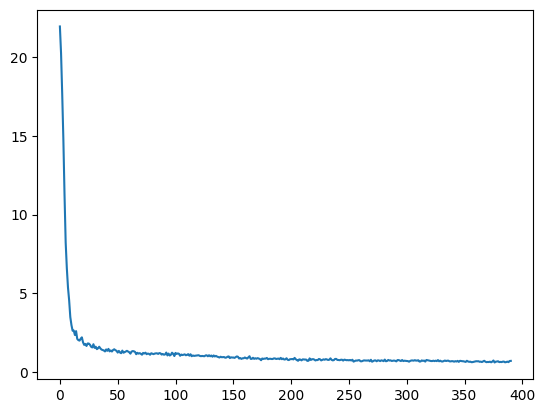

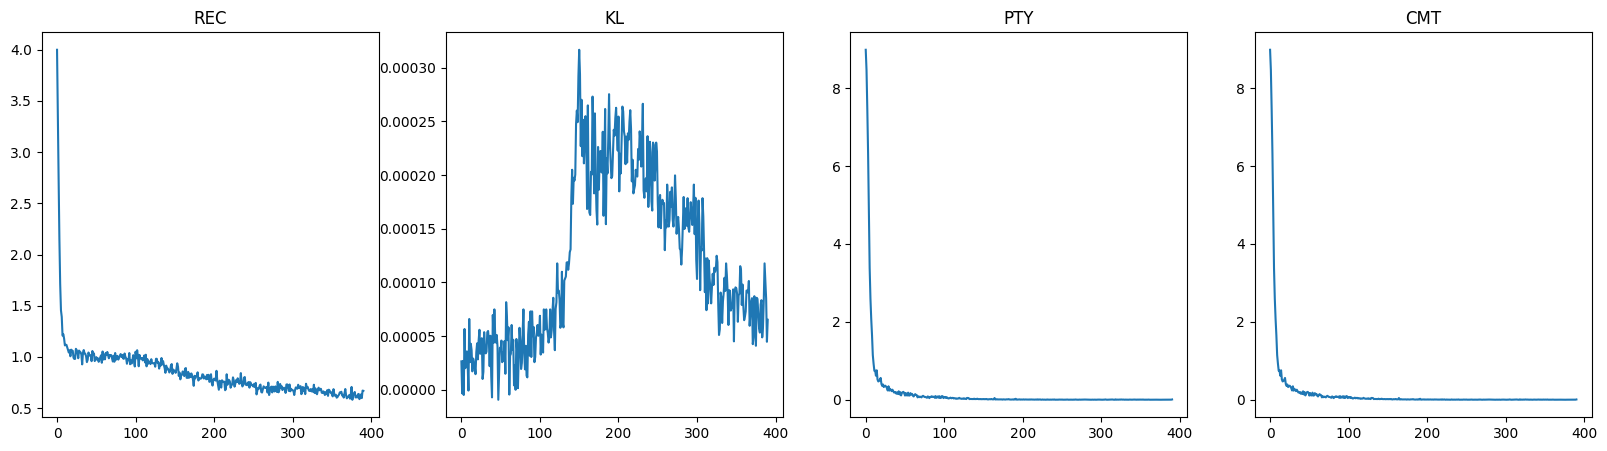

In [38]:
import untils
from COBWEBNN import CobwebNN, CobwebNNTreeLayer, TestModel
n_layers = 8
image_shape = (3, 32, 32)
image_shape_prod = image_shape[0] * image_shape[1] * image_shape[2]
cobweb = CobwebNN(image_shape=image_shape, n_layers=n_layers, n_hidden=512)

cobweb.to('cuda:1')
optimizer = optim.Adam(cobweb.parameters(), lr=2e-4)
train_loader = DataLoader(mnist_01_train, batch_size=128, shuffle=False)

all_losses = []
all_rec_losses = []
all_kl_losses = []
all_pty_losses = []
all_cmt_losses = []

epochs = 1
for _ in range(epochs):
    for j, (data, target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        # expand the data to 3 channels
        # data = data.expand(-1, 3, -1, -1)
        # pad to 32x32
        # data = F.pad(data, (2, 2, 2, 2), value=0)
        # print(data.shape)
        # print data range
        # print(data.min(), data.max())
        # break

        data = data.to('cuda:1')
        x, means, logvars, x_preds, p_x_nodes, p_node_xs, x_latent, _ = cobweb(data)
        loss = 0
        PTY = 0
        CMT = 0
        REC = 0
        KL = 0
        # break
        H = 0
        for i, (mean, logvar, x_pred, p_x_node, p_node_x) in enumerate(zip(means, logvars, x_preds, p_x_nodes, p_node_xs)):
            # print(x_pred.shape, data.shape)
            # print(x_pred.shape, data.shape)
            # REC = F.mse_loss(x_pred, data.view(-1, 28*28))
            # MSE betwwen two images
            # print(x_pred.shape, data.shape)
            # reconstruction loss
            REC += F.mse_loss(x_pred.view(-1, image_shape_prod), data.view(-1, image_shape_prod))
            # print(x_pred.max(), x_pred.min())
            # REC += F.binary_cross_entropy(x_pred.view(-1, image_shape_prod), data.view(-1, image_shape_prod))

            # prototype loss
            # PTY += (torch.norm(x_latent.unsqueeze(1) - mean.unsqueeze(0), p=2, dim=-1) * p_node_x).sum(dim=-1).mean() # shape (batch_size, n_clusters)
            # PTY += (F.mse_loss(x_latent.detach().unsqueeze(1), mean.unsqueeze(0), reduction='none').sum(dim=-1) * p_node_x).sum(dim=-1).mean()
            PTY += ((x_latent.detach().unsqueeze(1) - mean.unsqueeze(0)).pow(2).mean(dim=-1) * p_node_x).sum(dim=-1).mean()
            # print(PTY)
            # break
            # weighted by p_node_x
            # PTY_layer = PTY_layer * p_node_x
            # print(PTY)
            # PTY_layer = PTY_layer.sum(dim=-1).mean()
            # PTY += PTY_layer
            # print(PTY.shape)
            # print(PTY)

            # commitment loss
            # CMT_layer = torch.norm(x_latent.unsqueeze(1) - mean.detach().unsqueeze(0), p=2, dim=-1) # shape (batch_size, n_clusters)
            # CMT_layer = F.mse_loss(x_latent.unsqueeze(1), mean.detach().unsqueeze(0), reduction='none').sum(dim=-1)
            CMT_layer = (x_latent.unsqueeze(1) - mean.detach().unsqueeze(0)).pow(2).mean(dim=-1)
            CMT_layer = CMT_layer * p_node_x
            CMT_layer = CMT_layer.sum(dim=-1).mean()
            CMT += CMT_layer

            # break
             #shape (batch_size, n_hidden)

            KL += untils.cross_entropy_regularization(p_node_x, depth=n_layers - i, lambda_=200)
            # LOG_PROB = -p_x_node.sum(dim=-1).mean()
            # if LOG_PROB < 0:
            #     assert False
            # print(REC, KL)
            # break
            # print(p_x_node)
            # print(KL)
            # KLD between q(z|x) and p(z)
            # KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
            # if i == 0: # leaf level
                # some of entropy of leaf nodes
                # H = torch.sum(0.5 * (torch.log(2 * torch.tensor(torch.pi)) + logvar) + 0.5)
                # print(H)
            # if i == n_layers - 1: # root level
                # H -= torch.sum(0.5 * (torch.log(2 * torch.tensor(torch.pi)) + logvar) + 0.5)
            # print(H)
        loss += REC + PTY + CMT + KL
        # loss += H * 0.02
        # break

            # print(KLD.item(), REC.item())
            # break
        # print(loss.item())

        loss.backward()
        optimizer.step()
        all_losses.append(loss.item())
        all_rec_losses.append(REC.item())
        all_kl_losses.append(KL.item())
        all_pty_losses.append(PTY.item())
        all_cmt_losses.append(CMT.item())
        

        # if j == 10:
            # break



        # break
        # output.loss.backward()
        # optimizer.step()
        # if i % 100 == 0:
            # print(f"Epoch {_} Iter {i} Loss: {output.loss.item()}")

plt.plot(all_losses)
# 1x4 subplot for 4 losses
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].plot(all_rec_losses)
axs[0].set_title("REC")
axs[1].plot(all_kl_losses)
axs[1].set_title("KL")
axs[2].plot(all_pty_losses)
axs[2].set_title("PTY")
axs[3].plot(all_cmt_losses)
axs[3].set_title("CMT")
plt.show()

# untils.viz_prototypes(cobweb)

In [45]:
untils.viz_prototypes(cobweb, shape=image_shape, conved_shape=(cobweb.out_channels, cobweb.H_conv, cobweb.W_conv))
# untils.viz_batch_reconstruction(cobweb, mnist_01_test, device='mps')
# untils.viz_sampled_x(cobweb, mnist_01_test, device='mps')

AttributeError: 'CobwebNN' object has no attribute 'out_channels'

In [15]:
# train_loader = DataLoader(mnist_01_train, batch_size=128, shuffle=False)
# test_loader = DataLoader(mnist_01_test, batch_size=128, shuffle=False)

untils.model_forzen_classification(cobweb, mnist_01_train, mnist_01_test, device='cuda:1')

 72%|███████▏  | 280/391 [00:01<00:00, 251.60it/s]


KeyboardInterrupt: 

tensor([100,  49, 118,  24, 129, 131, 191,  53,  43,  44, 216, 121,  34, 204,
         99, 169, 216,  77,  20,  96, 204, 233, 140, 169, 153,  77,  81, 189,
        244, 180, 179, 158, 114, 202, 231, 250,  81, 169, 160, 231,  88, 169,
         96, 159, 110,  34,  34, 160,  57, 241, 169,  86, 244,  88,  81,  95,
        239,  47,  47, 173, 242, 159, 164, 210,  21, 191, 111, 229, 200,  45,
         74, 246, 114,  58, 145,  82,  36, 111, 245,  96,  74,  64,  44,  47,
         44, 114, 239, 161, 169, 191, 224, 196, 249, 155, 231, 189,  61,  88,
        254, 124,  95, 173, 140,  47,  67, 122, 173, 210, 191,  61, 212,   8,
         13, 246, 169, 226, 251, 101, 249, 149, 220,  58,  81, 232, 155, 167,
        220, 179,  45,  17,  20,   1, 178,  13,   3,  43,  23,  34, 210, 220,
        169, 128, 249, 153,  49, 202, 159, 226, 254, 164,  34,  86, 153, 233,
        239, 164,  98, 144, 159,  44,  44,  44,  26, 246,  60, 124,  24, 151,
        173, 210, 233, 151,  51, 169, 101, 147,  13, 246, 180, 1

AttributeError: 'CobwebNN' object has no attribute 'pre_quantization_conv'

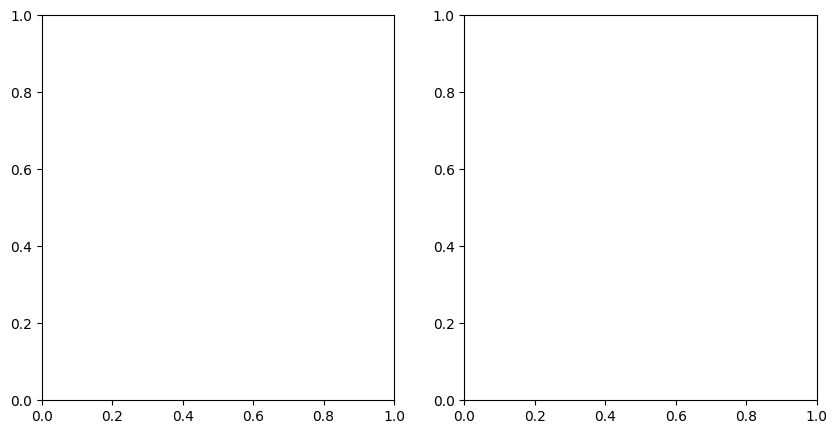

In [14]:
untils.viz_clusters(cobweb, mnist_01_test, device='cuda:1', n_data=1000)

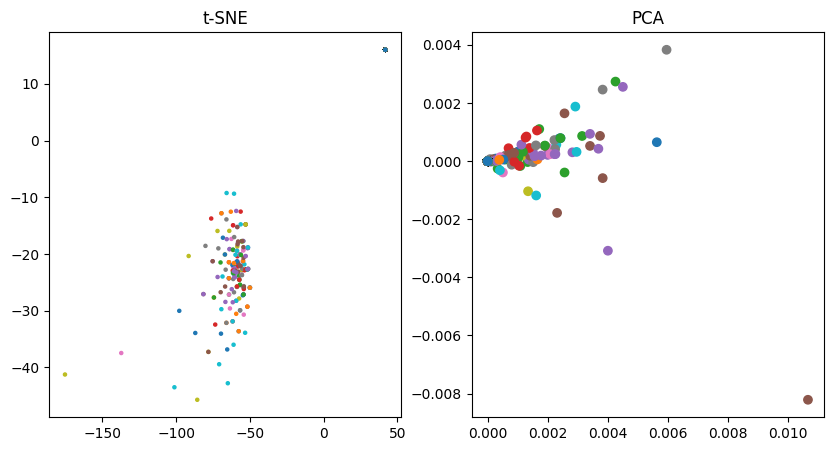

In [ ]:
untils.viz_clusters(cobweb, mnist_01_test, device='mps', n_data=500)

### Visualize examplar images

In [42]:
def viz_examplar(model, test_data, n_data=1000, device='cuda', layer=3, k=10):
    # get image representations
    recons = None
    image_labels = []

    test_loader = DataLoader(test_data, batch_size=n_data, shuffle=True)

    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            # print(data.shape)
            x, means, logvars, x_preds, p_x_nodes, p_node_xs, x_latent, _ = model(data)
            # x_latent: shape (batch_size, n_hidden)
            clusters = means[-layer].detach().cpu() # shape (n_clusters, n_hidden)
            x_latent = x_latent.detach().cpu() # shape (batch_size, n_hidden)
            # print(clusters.shape)
            # get the k nearest neighbors for each cluster
            # get the distance between each x_latent and each cluster
            distances = torch.norm(x_latent.unsqueeze(1) - clusters.unsqueeze(0), p=2, dim=-1).cpu() # shape (batch_size, n_clusters)
            # get the k nearest neighbors
            print(distances.shape)
            print(x_latent.shape) # (batch_size, n_hidden)
            # print(distances)
            print(distances.T) # (n_clusters, batch_size)
            _, topk = distances.T.topk(k, dim=-1, largest=False)
            print(topk.shape) # (n_clusters, k)
            # print(topk)
            # for each cluster, index the top k nearest neighbors from x_latent, return a n_clusters x k x n_hidden tensor
            examplars = torch.stack([x_latent[topk[i]] for i in range(topk.shape[0])]).to(device)
            # print(examplars.shape)

            examplars = examplars.view(-1, model.n_hidden) # shape (n_clusters * k, n_hidden)

            # examplars = clusters.view(-1, model.n_hidden).to(device) # shape (n_clusters, n_hidden)

            # pass the examplars to the decoder
            x_pred = model.decoder(examplars.view(-1, model.n_hidden, 1, 1)) # shape (n_clusters * k, 3, 32, 32)
            # x_pred = model.decoder(model.decoder_fc(examplars).view(-1, 64, 8, 8)) # shape (n_clusters * k, 3, 32, 32)
            # print(x_pred.shape)

            x_pred = x_pred.view(topk.shape[0], topk.shape[1], 3, 32, 32).detach().cpu() # shape (n_clusters, k, 3, 32, 32)
            # print(x_pred.shape)

            # image_labels.append(target)
            break

    # plot the examplars
    fig, axes = plt.subplots(topk.shape[1], topk.shape[0], figsize=(8, 8),
                            gridspec_kw={'wspace': 0, 'hspace': 0})
    for i in range(topk.shape[0]):
        if topk.shape[1] == 1:
            axes[i].imshow(x_pred[i, 0].permute(1, 2, 0).numpy())
            axes[i].axis('off')
            continue
        for j in range(topk.shape[1]):
            axes[j, i].imshow(x_pred[i, j].permute(1, 2, 0).numpy())
            axes[j, i].axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    plt.show()



torch.Size([1000, 16])
torch.Size([1000, 512])
tensor([[0.3602, 0.6547, 0.5048,  ..., 0.3680, 0.2629, 0.2712],
        [0.3579, 0.6525, 0.5025,  ..., 0.3657, 0.2606, 0.2689],
        [0.3621, 0.6543, 0.5060,  ..., 0.3698, 0.2646, 0.2731],
        ...,
        [0.3613, 0.6541, 0.5051,  ..., 0.3690, 0.2637, 0.2725],
        [0.3606, 0.6547, 0.5050,  ..., 0.3689, 0.2640, 0.2724],
        [0.3616, 0.6558, 0.5057,  ..., 0.3694, 0.2645, 0.2724]])
torch.Size([16, 1])


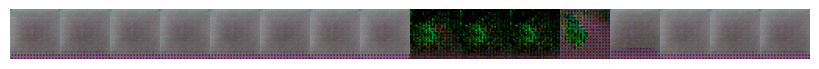

In [40]:
viz_examplar(cobweb, mnist_01_test, n_data=1000, device='cuda:1', layer=5, k=1)

torch.Size([1000, 16])
torch.Size([1000, 512])
tensor([[0.3823, 0.4296, 0.2915,  ..., 0.5182, 0.4330, 0.6990],
        [0.3796, 0.4275, 0.2897,  ..., 0.5158, 0.4308, 0.6961],
        [0.3825, 0.4314, 0.2937,  ..., 0.5188, 0.4340, 0.7001],
        ...,
        [0.3840, 0.4305, 0.2926,  ..., 0.5179, 0.4338, 0.6986],
        [0.3842, 0.4301, 0.2928,  ..., 0.5179, 0.4333, 0.6992],
        [0.3838, 0.4312, 0.2933,  ..., 0.5185, 0.4335, 0.6994]])
torch.Size([16, 10])


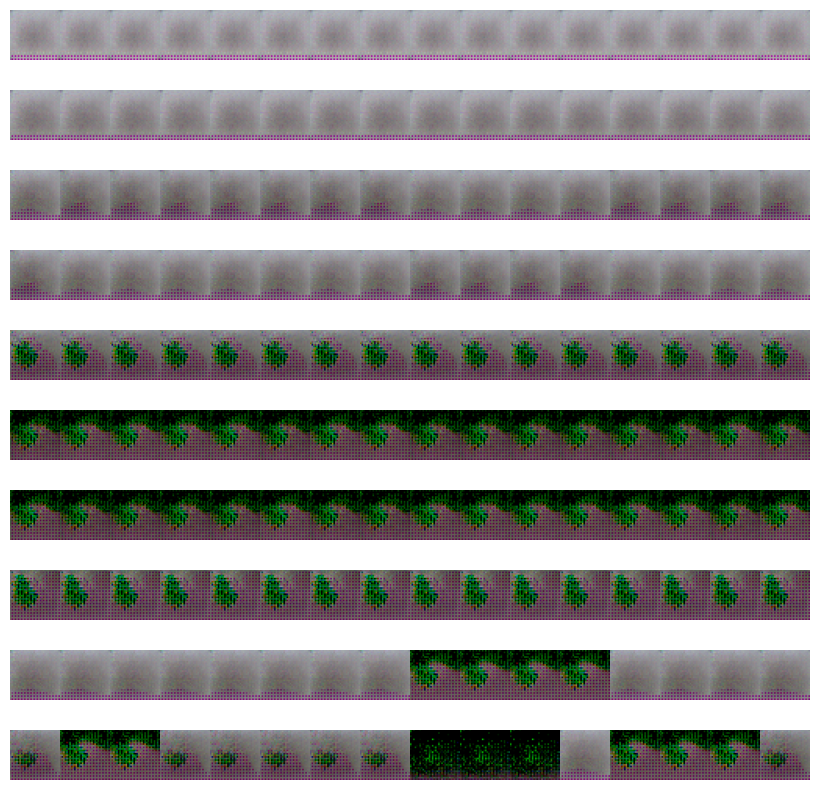

In [43]:
viz_examplar(cobweb, mnist_01_test, n_data=1000, device='cuda:1', layer=5, k=10)

In [ ]:
# get leaves
leaves = cobweb.leaves.detach()
logvars = cobweb.leaves_logvar.detach()

test_loader = DataLoader(mnist_01_test, batch_size=128, shuffle=False)
for test_image, target in test_loader:
    # encode image
    with torch.no_grad():
        latent = cobweb.mu(cobweb.fc(test_image.view(-1, image_shape_prod).to('mps')))
        # calculate the distance between the latent and the leaves
        # print(latent.shape, leaves.shape)
        dist = torch.norm(latent.unsqueeze(1) - leaves, p=2, dim=-1)
        probs = F.softmax(-dist, dim=-1)
        # print(probs.shape)
        pred = probs.argmax(dim=-1).cpu()

        # change target mapping: 0 -> 0, 1 -> 2, 2 -> 3, 3 -> 1
        target = target.cpu()
        target = torch.tensor([3 if t == 0 else 1 if t == 1 else 0 if t == 2 else 2 for t in target])

        correct = (pred == target).sum().item()
        print(correct)

        break

39


In [34]:
import torch
import os
# Add Graphviz's bin directory to the PATH.
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"
from torchviz import make_dot
# model = CobwebNN(n_hidden=784, n_layers=4, imprint_dim=10)
model = CobwebNN(image_shape=image_shape, n_layers=n_layers, n_hidden=512,
                  encoder=encoder, decoder=decoder)
x = torch.randn(5, 3, 32, 32)
y = torch.randn(5, 3, 32, 32)

x, means, logvars, x_preds, p_x_nodes, p_node_xs = model(x)
loss = 0
for i, (mean, logvar, x_pred, p_x_node, p_node_x) in enumerate(zip(means, logvars, x_preds, p_x_nodes, p_node_xs)):
    loss += F.mse_loss(x_pred.view(-1, 3*32*32), y.view(-1, 3*32*32))

dot = make_dot(loss, params=dict(model.named_parameters()))
dot.render("compute_graph", format="pdf")

TypeError: super(type, obj): obj must be an instance or subtype of type

cluster_weight: [[0.6906636]]


/var/folders/20/sbb3zm0s7t93v_80z1k489v00000gp/T/ipykernel_35710/1089314447.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  right_mean = (root_mean - cluster_weight * left_mean) / (1 - cluster_weight)


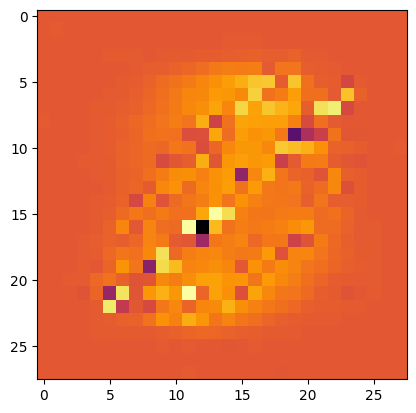

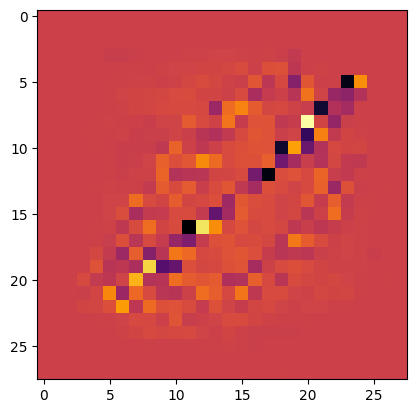

In [ ]:
# print left and right mean
left_mean = cobwebNN.layers[0].mean_l.cpu().detach().numpy()
cluster_weight = F.sigmoid(cobwebNN.layers[0].cluster_weight.cpu().detach()).numpy()
print(f"cluster_weight: {cluster_weight}")
right_mean = (root_mean - cluster_weight * left_mean) / (1 - cluster_weight) 

# display the first image
plt.imshow(left_mean.reshape(-1, 28), cmap='inferno')
plt.show()
plt.imshow(right_mean.reshape(-1, 28), cmap='inferno')
plt.show()

Epoch 10/10: 100%|██████████| 774/774 [00:01<00:00, 609.07it/s, loss=0.0467]


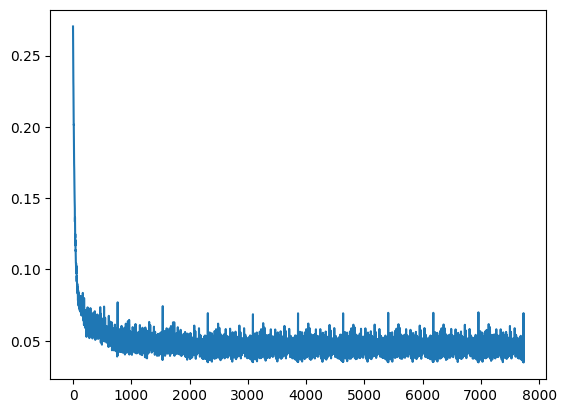

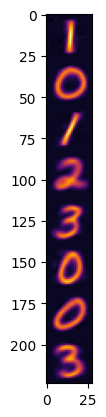

In [ ]:
test_model = TestModel()

test_model.to('mps')
optimizer = optim.Adam(test_model.parameters(), lr=1e-2)

untils.train_model(test_model, mnist_01_train, True, optimizer, epochs=10, hard=True, batch_size=32, show_loss=True, 
                   device='mps', verbose=False, early_break=False)

# print left and right mean
chidlren_mean = test_model.children_mean.detach().cpu().numpy()
# display the first image
plt.imshow(chidlren_mean.reshape(-1, 28), cmap='inferno')
plt.show()
# plt.imshow(chidlren_mean[1].reshape(28, 28), cmap='inferno')
# plt.show()


/var/folders/20/sbb3zm0s7t93v_80z1k489v00000gp/T/ipykernel_31960/1151203458.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l1_split = torch.tensor(l1_split > 0.5, dtype=torch.float32)


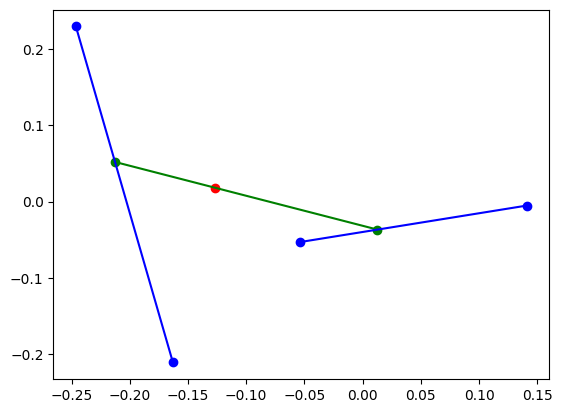

In [ ]:
# random 2d data
n = 100
data = torch.randn(n, 2)
l1_split = torch.rand(n)
l1_split = torch.tensor(l1_split > 0.5, dtype=torch.float32)
data_l1_left = data[l1_split == 1]
data_l1_right = data[l1_split == 0]

l2_split_left = torch.rand(data_l1_left.size(0)) > 0.5
l2_split_right = torch.rand(data_l1_right.size(0)) > 0.5
data_l2_left_left = data_l1_left[l2_split_left]
data_l2_left_right = data_l1_left[~l2_split_left]

data_l2_right_left = data_l1_right[l2_split_right]
data_l2_right_right = data_l1_right[~l2_split_right]

# plot centorids
data_mean = data.mean(dim=0)
mean_l1_left = data_l1_left.mean(dim=0)
mean_l1_right = data_l1_right.mean(dim=0)
mean_l2_left_left = data_l2_left_left.mean(dim=0)
mean_l2_left_right = data_l2_left_right.mean(dim=0)
mean_l2_right_left = data_l2_right_left.mean(dim=0)
mean_l2_right_right = data_l2_right_right.mean(dim=0)

# plot the means
# plt.scatter(data[:, 0], data[:, 1])
plt.scatter(data_mean[0], data_mean[1], c='r')
plt.scatter(mean_l1_left[0], mean_l1_left[1], c='g')
plt.scatter(mean_l1_right[0], mean_l1_right[1], c='g')
# connect these two means
plt.plot([mean_l1_right[0], mean_l1_left[0]], [mean_l1_right[1], mean_l1_left[1]], c='g')

plt.scatter(mean_l2_left_left[0], mean_l2_left_left[1], c='b')
plt.scatter(mean_l2_left_right[0], mean_l2_left_right[1], c='b')
# connect these two means
plt.plot([mean_l2_left_left[0], mean_l2_left_right[0]], [mean_l2_left_left[1], mean_l2_left_right[1]], c='b')

plt.scatter(mean_l2_right_left[0], mean_l2_right_left[1], c='b')
plt.scatter(mean_l2_right_right[0], mean_l2_right_right[1], c='b')
# connect these two means
plt.plot([mean_l2_right_left[0], mean_l2_right_right[0]], [mean_l2_right_left[1], mean_l2_right_right[1]], c='b')


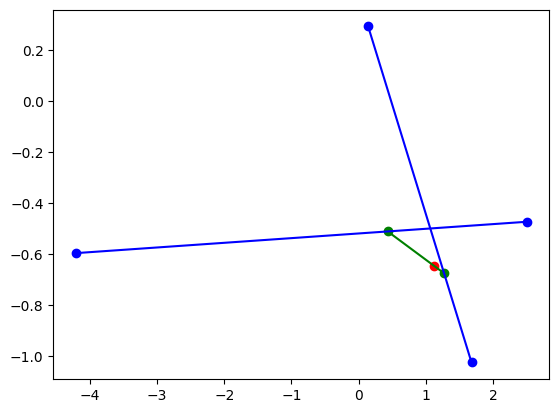

In [ ]:
root_mean = torch.randn(2)
left_mean = torch.randn(2)
l1_alpha = torch.rand(1)
right_mean = (root_mean - l1_alpha * left_mean) / (1 - l1_alpha)

left_left_mean = torch.randn(2)
left_alpha = torch.rand(1)
left_right_mean = (left_mean - left_alpha * left_left_mean) / (1 - left_alpha)

right_left_mean = torch.randn(2)
right_alpha = torch.rand(1)
right_right_mean = (right_mean - right_alpha * right_left_mean) / (1 - right_alpha)

# plot the means
plt.scatter(root_mean[0], root_mean[1], c='r')

plt.scatter(left_mean[0], left_mean[1], c='g')
plt.scatter(right_mean[0], right_mean[1], c='g')
# connect these two means
plt.plot([right_mean[0], left_mean[0]], [right_mean[1], left_mean[1]], c='g')

plt.scatter(left_left_mean[0], left_left_mean[1], c='b')
plt.scatter(left_right_mean[0], left_right_mean[1], c='b')
# connect these two means
plt.plot([left_left_mean[0], left_right_mean[0]], [left_left_mean[1], left_right_mean[1]], c='b')

plt.scatter(right_left_mean[0], right_left_mean[1], c='b')
plt.scatter(right_right_mean[0], right_right_mean[1], c='b')
# connect these two means
plt.plot([right_left_mean[0], right_right_mean[0]], [right_left_mean[1], right_right_mean[1]], c='b')
